In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
sites = ['Calperum', 'Whroo', 'WombatStateForest','Tumbarumba', 'WallabyCreek']


cpr_flux_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/ozflux/L6/Calperum_L6.nc')
cpr_SILO_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/climate/SILO/processed/flux_sites/cpr_2000-2024.nc')
whr_flux_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/ozflux/L6/Whroo_L6.nc')
whr_SILO_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/climate/SILO/processed/flux_sites/whr_2000-2024.nc')
wom_flux_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/ozflux/L6/WombatStateForest_L6.nc')
wom_SILO_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/climate/SILO/processed/flux_sites/wom_2000-2024.nc')
tum_flux_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/ozflux/L6/Tumbarumba_L6.nc')
tum_SILO_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/climate/SILO/processed/flux_sites/tum_2000-2024.nc')
wac_flux_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/ozflux/L6/WallabyCreek_L6.nc')
wac_SILO_data = xr.open_dataset(f'/Users/phelps/PhD_Project/data/climate/SILO/processed/flux_sites/wac_2000-2024.nc')



In [104]:
def get_site_data(site_name):
    if site_name == 'Calperum':
        return cpr_flux_data, cpr_SILO_data
    elif site_name == 'Whroo':
        return whr_flux_data, whr_SILO_data
    elif site_name == 'WombatStateForest':
        return wom_flux_data, wom_SILO_data
    elif site_name == 'Tumbarumba':
        return tum_flux_data, tum_SILO_data
    elif site_name == 'WallabyCreek':
        return wac_flux_data, wac_SILO_data
    else:
        raise ValueError(f"Site '{site_name}' not recognized.")
    
def make_df(site_name):
    site_flux_data, site_SILO_data = get_site_data(site_name)



    flux_df = site_flux_data.to_dataframe().reset_index()

    SILO_df = site_SILO_data.to_dataframe().reset_index()

    SILO_df['time'] = pd.to_datetime(SILO_df['time'])
    SILO_df = SILO_df.set_index('time')

    flux_met = flux_df[['time','Precip','Ta','Fsd','RH', 'VPD']].copy()
    flux_met['time'] = pd.to_datetime(flux_met['time'])
    flux_met = flux_met.set_index('time')

    flux_met_daily =flux_met.resample('D').agg(
        daily_rain=('Precip', 'sum'),
        max_temp=('Ta', 'max'),
        min_temp=('Ta', 'min'),
        radiation=('Fsd', 'mean'),
        rh_tmax=('RH', 'max'),
        rh_tmin=('RH', 'min'),
        vp_deficit=('VPD', 'mean')
    )

    #convert units

    flux_met_daily['radiation'] = flux_met_daily['radiation'] * 0.0864  # W/m2 to MJ/m2/day
    flux_met_daily['vp_deficit'] = flux_met_daily['vp_deficit'] * 10 # kPa to hPa

    combined_df = flux_met_daily.join(SILO_df, how='inner', lsuffix='_flux', rsuffix='_SILO')
    return combined_df

combined_df = make_df('Calperum')

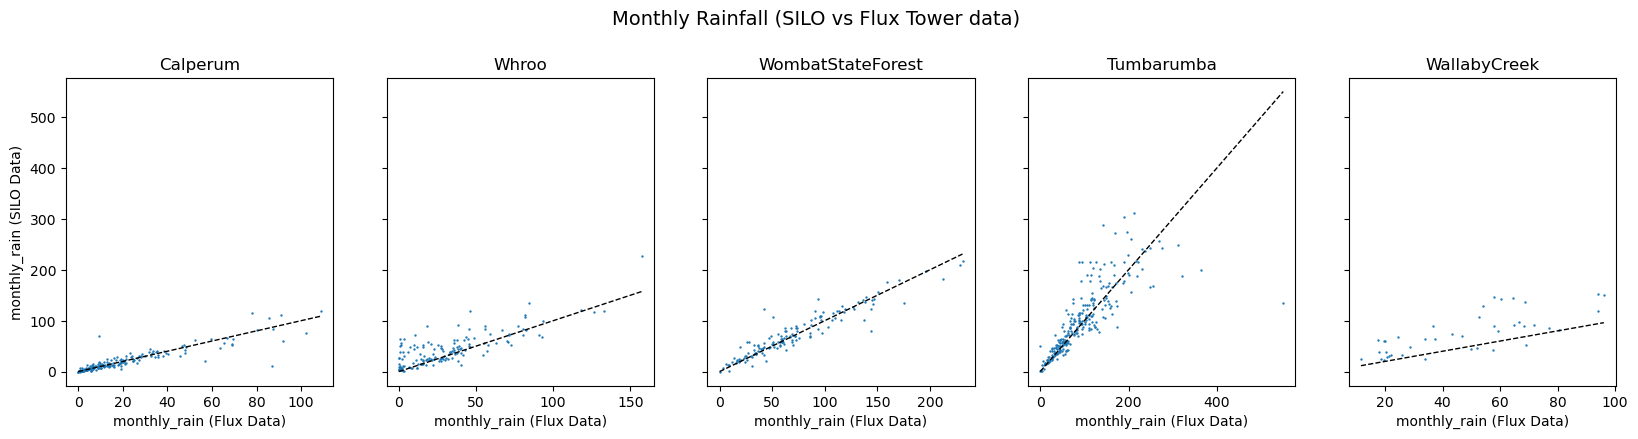

In [140]:
vars= ['max_temp', 'min_temp', 'radiation', 'daily_rain', 'monthly_rain']
var = vars[3]

fig,axes =plt.subplots(1,5,figsize=(20,4),sharey=True)


for ax, site in zip(axes, sites):
        var='daily_rain'
        combined_df = make_df(site)

        combined_df = combined_df.resample('ME').sum()

        
        ax.scatter(combined_df[f'{var}_flux'], combined_df[f'{var}_SILO'], s=0.5)
        ax.plot([combined_df[f'{var}_flux'].min(), combined_df[f'{var}_flux'].max()], 
                [combined_df[f'{var}_flux'].min(), combined_df[f'{var}_flux'].max()], 
                color='black', linestyle='--', linewidth=1)
        ax.set_title(site)
        var='monthly_rain'
        if ax==axes[0]:
            ax.set_ylabel(f'{var} (SILO Data)')
        ax.set_xlabel(f'{var} (Flux Data)')

plt.suptitle('Monthly Rainfall (SILO vs Flux Tower data)', fontsize=14, y=1.05)

plt.savefig('monthly_rain_comparison', dpi=300)


Text(0, 0.5, 'daily_rain (SILO Data)')

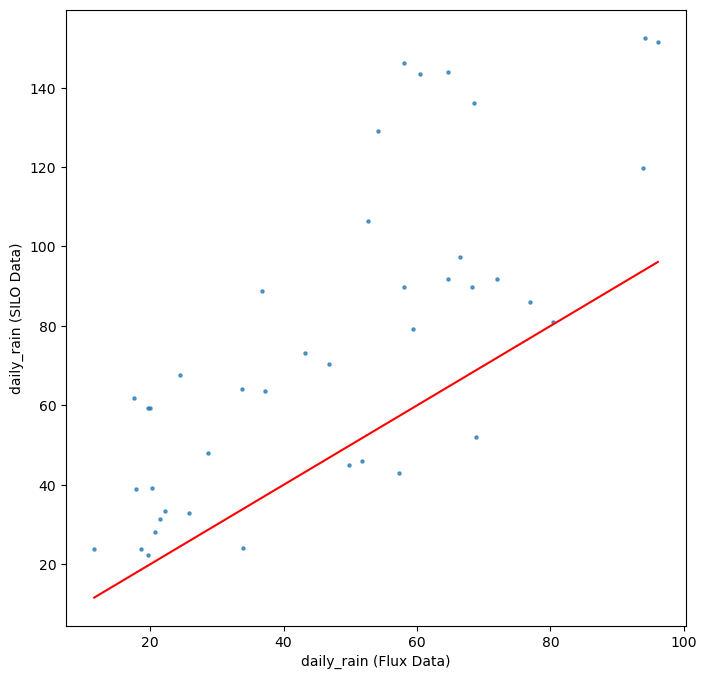

In [101]:
combined_monthly = combined_df.resample('ME').sum()

fig,ax =plt.subplots(figsize=(8,8))
ax.scatter(combined_monthly[f'{var}_flux'], combined_monthly[f'{var}_SILO'], s=5, alpha=0.7)
ax.plot([combined_monthly[f'{var}_flux'].min(), combined_monthly[f'{var}_flux'].max()], 
        [combined_monthly[f'{var}_flux'].min(), combined_monthly[f'{var}_flux'].max()], 
        color='red')
ax.set_xlabel(f'{var} (Flux Data)')
ax.set_ylabel(f'{var} (SILO Data)')